In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
# spark_version = 'spark-3.0.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

## import matplotlib, etc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.18.jar").getOrCreate()

In [3]:
# Read in data from S3 Buckets
# Read in data from S3 Buckets
from pyspark import SparkFiles
url="https://markdatabucket.s3.amazonaws.com/cbb.csv"

spark.sparkContext.addFile(url)
spark_data_df = spark.read.csv(SparkFiles.get("cbb.csv"), sep=",", header=True, inferSchema=True)

# need to convert spark dataframe to pandas dataframe
cbb_df = spark_data_df.toPandas()

# Show DataFrame
cbb_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1,2017


In [4]:
#filtering down to one year of data, using dot notation and a conditional statement "2019"
cbb_2019_df = cbb_df[cbb_df.YEAR == 2019]
cbb_2019_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019
6,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1,2019
16,Duke,ACC,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2,E8,1,2019
17,Purdue,B10,36,26,122.8,94.3,0.9539,53.6,49.0,15.8,18.6,34.5,27.0,29.9,31.7,51.5,47.2,37.4,34.2,67.0,6.1,E8,3,2019
27,Kentucky,SEC,37,30,117.5,89.8,0.9568,53.0,46.6,18.6,17.9,36.8,25.5,41.9,26.8,52.9,43.6,35.4,34.3,66.9,8.8,E8,2,2019


In [5]:
# duplicate postseason column to later use as binary option
cbb_2019_df['POSTSEASON_BINARY'] = cbb_2019_df['POSTSEASON']
cbb_2019_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_BINARY
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019,2ND
6,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1,2019,Champions
16,Duke,ACC,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2,E8,1,2019,E8
17,Purdue,B10,36,26,122.8,94.3,0.9539,53.6,49.0,15.8,18.6,34.5,27.0,29.9,31.7,51.5,47.2,37.4,34.2,67.0,6.1,E8,3,2019,E8
27,Kentucky,SEC,37,30,117.5,89.8,0.9568,53.0,46.6,18.6,17.9,36.8,25.5,41.9,26.8,52.9,43.6,35.4,34.3,66.9,8.8,E8,2,2019,E8


In [6]:
cbb_2019_df['POSTSEASON_BINARY'] = cbb_2019_df['POSTSEASON']
cbb_2019_df.POSTSEASON_BINARY[cbb_2019_df.POSTSEASON_BINARY == "NA"] = 0
cbb_2019_df.POSTSEASON_BINARY[cbb_2019_df.POSTSEASON_BINARY != 0] = 1
cbb_2019_df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_BINARY
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3,2019,1
6,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1,2019,1
16,Duke,ACC,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6,11.2,E8,1,2019,1
17,Purdue,B10,36,26,122.8,94.3,0.9539,53.6,49.0,15.8,18.6,34.5,27.0,29.9,31.7,51.5,47.2,37.4,34.2,67.0,6.1,E8,3,2019,1
27,Kentucky,SEC,37,30,117.5,89.8,0.9568,53.0,46.6,18.6,17.9,36.8,25.5,41.9,26.8,52.9,43.6,35.4,34.3,66.9,8.8,E8,2,2019,1
29,Gonzaga,WCC,37,33,123.4,89.9,0.9744,59.0,44.2,14.9,19.0,31.5,26.8,35.3,25.9,61.4,43.4,36.3,30.4,72.0,7.0,E8,1,2019,1
32,Michigan St.,B10,39,32,119.9,91.0,0.9597,55.2,43.9,18.5,14.9,33.9,26.4,33.6,27.5,54.3,41.9,37.8,31.6,68.6,10.7,F4,2,2019,1
39,Auburn,SEC,39,30,121.3,95.2,0.9420,54.4,51.7,16.8,24.6,31.6,32.8,30.9,36.4,51.7,51.4,38.1,34.8,69.3,6.1,F4,5,2019,1
84,Davidson,A10,33,24,107.3,99.8,0.6974,53.1,48.3,16.7,16.7,23.3,24.8,28.3,30.0,52.8,47.3,35.6,33.0,66.1,-0.9,NA,NA,2019,0
85,Dayton,A10,33,21,111.1,98.9,0.7915,56.1,47.9,18.8,16.8,26.9,27.4,32.1,23.8,59.5,47.7,33.2,32.1,66.1,-2.3,NA,NA,2019,0


In [7]:
# Assign the data to X and y
# Note: Sklearn requires a two-dimensional array of values
# so we use reshape to create this

X = cbb_2019_df['2P_O'].values.reshape(-1, 1)
y = cbb_2019_df.POSTSEASON_BINARY
y=y.astype('int')


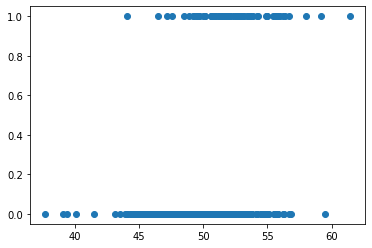

In [8]:
# Plot the data
plt.scatter(X, y)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [10]:
# Create the model and fit the model to the data

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:

classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8143939393939394
Testing Data Score: 0.797752808988764


In [13]:
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   [0 0 0 0 0 0 0 0 0 0]
First 10 Actual labels: [0, 0, 0, 1, 1, 1, 1, 0, 0, 0]


In [14]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,1
4,0,1
...,...,...
84,0,0
85,0,0
86,0,0
87,0,0
